<a href="https://colab.research.google.com/github/mgrafu/CUNY-ML-DeepLearning/blob/main/CUNY_GC_ML_Final_Project_Sentiment_analysis_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade matplotlib

In [ ]:
import random
import string 
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.legacy import data, datasets

# **Complementary Functions**

In [ ]:
# Check how many parameters to train are in a model.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# Compute accuracy per batch.
def binary_accuracy(preds, y):
    # Round predictions to the closest integer.
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    return correct.sum() / len(correct)

In [ ]:
# Calculate the duration of a process.
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time  / 60)
    elapsed_secs = int(elapsed_time -  (elapsed_mins * 60))
    return  elapsed_mins, elapsed_secs

# **Load Data**

In [ ]:
BATCH_SIZE = 64
MAX_VOCAB_SIZE = 25_000
SEED = 42

start_time = time.time()

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Define the fields.
TEXT = data.Field(tokenize='spacy',
                  tokenizer_language='en_core_web_sm',
                  include_lengths=True)
LABEL = data.LabelField(dtype=torch.float)

print("Loading data from server...")
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state=random.seed(SEED))
print(train_data[0].__dict__.keys())

# Build the vocabulary with GloVe.
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)
print("Vocabulary built successfully.")

# Determine whether to use CUDA or not.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create iterator for the dataset.
train_iter, valid_iter, test_iter = data.BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size=BATCH_SIZE,
    sort_within_batch=True, device=device)
print("Iterators built successfully.")

mins, secs = epoch_time(start_time, time.time())
print(f"Loading Time: {mins}m {secs}s")

# **LSTM Architecture**

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers, bidirectional, dropout, pad_idx):
        super().__init__()

        # Define layers in the model.        
        self.embedding = nn.Embedding(vocab_size, embedding_dim,
                                      padding_idx=pad_idx)
        
        self.LSTM = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        # Compute embeddings.
        # text format: [len(sent), batch_size]
        # embedded format: [len(sent), batch_size, embedding_dim]
        embedded = self.dropout(self.embedding(text))
        
        # Pack sequence.
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded,
                                                            text_lengths.to("cpu"),
                                                            enforce_sorted=False)
        # Run through LSTM.
        packed_output, (hidden, cell) = self.LSTM(packed_embedded)
        
        # Unpack sequence.
        # Output over padding tokens are zero tensors.
        # output format: [len(sent), batch_size, hidden_dim * n_directions]
        # hidden format: [n_layers * n_directions, batch_size, hidden_dim]
        # cell format: [n_layers * n_directions, batch_size, hidden_dim]
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        
        # Apply dropout and concat the last forward and backward hidden layers.
        # hidden format: [batch_size, hidden_dim * n_directions]
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
    
        return self.fc(hidden)

In [ ]:
def train_LSTM(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label.float())
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        batch_size = len(iterator)

        if i % 50 == 0:
            print(f"[{i:03}/{len(iterator)}]:", end=" ")
            print(f"epoch_acc: {epoch_acc / batch_size:.2f}")
    return epoch_loss / batch_size, epoch_acc / batch_size

In [ ]:
def evaluate_LSTM(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)

            loss = criterion(predictions, batch.label.float())
            acc = binary_accuracy(predictions, batch.label)
        
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            batch_size = len(iterator)

    return epoch_loss / batch_size, epoch_acc / batch_size

In [ ]:
def train_eval_LSTM(n_layers=1, dropout=0, num_epochs=2):
    # Set variable model hyperparameters:
    N_LAYERS = n_layers
    DROPOUT = dropout

    # Set fixed model hyperparameters.
    INPUT_DIM = len(TEXT.vocab)
    EMBEDDING_DIM = 100
    HIDDEN_DIM = 256
    OUTPUT_DIM = 1
    BIDIRECTIONAL = True
    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
    
    # Instantiate model.
    model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 
                 N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
    print(f'The model has {count_parameters(model):,} trainable parameters')

    # Define the optimizer and loss function.
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss()

    # Pass the model and loss function to GPU.
    model = model.to(device)
    criterion = criterion.to(device)

    # Store accuracies per epoch.
    all_train_acc = []
    all_valid_acc = []

    # Train the model.
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        st = time.time()
        train_loss, train_acc = train_LSTM(model, train_iter, optimizer, criterion)
        valid_loss, valid_acc = evaluate_LSTM(model, valid_iter, criterion)    
        epoch_mins, epoch_secs = epoch_time(st, time.time())
        
        # Append to lists of accuracies.
        all_train_acc.append(train_acc)
        all_valid_acc.append(valid_acc)        

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'LSTM-model.pt')
            
        print(f'Epoch:  {epoch+1:03} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

    # Evaluate on test set.
    model.load_state_dict(torch.load('LSTM-model.pt'))
    test_loss, test_acc = evaluate_LSTM(model, test_iter, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
    print()

    return all_train_acc, all_valid_acc, test_acc

# **CNN Architecture**

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, 
                 output_dim, dropout, pad_idx):
        super(CNN, self).__init__()
        
        # Define layers in the model.        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, 
                                      padding_idx=pad_idx)
        
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, 
                                              out_channels=n_filters, 
                                              kernel_size=(fs, embedding_dim)) 
                                    for fs in filter_sizes])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # Permute text format.
        #      from: [len(sent), batch_size] 
        #      to: [batch_size, len(sent)]
        text = text.permute(1, 0)

        # Compute embeddings.
        # embedded format: [batch_size, len(sent), embedding_dim]
        embedded = self.embedding(text)
        # embedded format: [batch_size, 1, len(sent), embedding_dim]
        embedded = embedded.unsqueeze(1)
        
        # Perform convolution.
        # conved_n format: [batch_size, n_filters, len(sent) - filter_sizes[n] + 1]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]  
        
        # Apply max pooling.
        # pooled format: [len(filter_sizes), batch_size, n_filters]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        # Concatenate results from all filter sizes.
        # cat format: [batch_size, n_filters * len(filter_sizes)]
        cat = self.dropout(torch.cat(pooled, dim=1))
            
        return self.fc(cat)

In [ ]:
def train_CNN(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text).squeeze(1)
        
        loss = criterion(predictions, batch.label.float())
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        batch_size = len(iterator)

        if i % 50 == 0:
            print(f"[{i:03}/{len(iterator)}]:", end=" ")
            print(f"epoch_acc: {epoch_acc / batch_size:.2f}")
    return epoch_loss / batch_size, epoch_acc / batch_size

In [ ]:
def evaluate_CNN(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text).squeeze(1)

            loss = criterion(predictions, batch.label.float())
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            batch_size = len(iterator)
        
    return epoch_loss / batch_size, epoch_acc / batch_size

In [ ]:
def train_eval_CNN(filter_sizes=[3, 4, 5], dropout=0.5, num_epochs=2):
    # Set variable model hyperparameters:
    FILTER_SIZES = filter_sizes
    DROPOUT = dropout

    # Set fixed model hyperparameters.
    INPUT_DIM = len(TEXT.vocab)
    EMBEDDING_DIM = 100
    N_FILTERS = 100
    OUTPUT_DIM = 1
    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

    # Instantiate model.
    model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, 
                OUTPUT_DIM, DROPOUT, PAD_IDX)
    print(f'The model has {count_parameters(model):,} trainable parameters')

    # Define the optimizer and loss function.
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss()

    # Pass the model and loss function to GPU.
    model = model.to(device)
    criterion = criterion.to(device)

    # Store accuracies per epoch.
    all_train_acc = []
    all_valid_acc = []

    # Train the model.
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_acc = train_CNN(model, train_iter, optimizer, criterion)
        valid_loss, valid_acc = evaluate_CNN(model, valid_iter, criterion)
        epoch_mins, epoch_secs = epoch_time(start_time, time.time())

        # Append to lists of accuracies.
        all_train_acc.append(train_acc)
        all_valid_acc.append(valid_acc)        

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'CNN-model.pt')
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    # Evaluate on test set.
    model.load_state_dict(torch.load('CNN-model.pt'))
    test_loss, test_acc = evaluate_CNN(model, test_iter, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
    print()

    return all_train_acc, all_valid_acc, test_acc

# **Combined Model Architecture**

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, 
                 dropout, pad_idx, hidden_dim, output_dim, n_layers, bidirectional):
        
        super().__init__()
        # Define layers in the model.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, 
                                      padding_idx=pad_idx)
        
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes])
        
        self.LSTM = nn.LSTM(n_filters, hidden_dim, num_layers=n_layers, 
                            bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
                
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        # Permute text format.
        #      from: [len(sent), batch_size] 
        #      to: [batch_size, len(sent)]
        text = text.permute(1, 0)

        # Compute embeddings.
        # embedded format: [batch_size, len(sent), embedding_dim]
        embedded = self.embedding(text)
        # embedded format: [batch_size, 1, len(sent), embedding_dim]
        embedded = embedded.unsqueeze(1)

        # Perform convolution.
        # conved_n format: [batch_size, n_filters, len(sent) - filter_sizes[n] + 1]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]  

        # Apply max pooling.
        # pooled format: [len(filter_sizes), batch_size, n_filters]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        # Stack the output matrices of all filter sizes.
        # stacked format: [len(filter_sizes), batch_size, n_filters]
        stacked = self.dropout(torch.stack(pooled))

        # Run stacked matrix through LSTM.
        # output format: [len(filter_sizes), batch_size, hidden_dim * n_directions]
        # hidden format: [n_layers * n_directions, batch_size, hidden_dim]
        # cell format: [n_layers * n_directions, batch_size, hidden_dim]
        output, (hidden, cell) = self.LSTM(stacked)
        
        # Apply dropout and concat the last forward and backward hidden layers.
        # hidden format: [batch_size, hidden_dim * n_directions]
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
            
        return self.fc(hidden)

In [ ]:
def train_CNN_LSTM(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        batch_size = len(iterator)

        if i % 50 == 0:
            print(f"[{i:03}/{len(iterator)}]:", end=" ")
            print(f"epoch_acc: {epoch_acc / batch_size:.2f}")
    return epoch_loss / batch_size, epoch_acc / batch_size

In [ ]:
def evaluate_CNN_LSTM(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
  
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            batch_size = len(iterator)
        
    return epoch_loss / batch_size, epoch_acc / batch_size

In [ ]:
def train_eval_CNN_LSTM(n_layers=2, dropout=0.5, 
                        filter_sizes=[3,4,5], num_epochs=2):
    # Set variable model hyperparameters:
    N_LAYERS = n_layers
    DROPOUT = dropout
    FILTER_SIZES = filter_sizes

    # Set fixed model hyperparameters.
    INPUT_DIM = len(TEXT.vocab)
    EMBEDDING_DIM = 100
    N_FILTERS = 100
    BIDIRECTIONAL = True
    HIDDEN_DIM = 256
    OUTPUT_DIM = 1
    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

    # Instantiate model.
    model = CNN_LSTM(INPUT_DIM, EMBEDDING_DIM, N_FILTERS,FILTER_SIZES, DROPOUT, 
                     PAD_IDX, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL)
    print(f'The model has {count_parameters(model):,} trainable parameters')

    # Define the optimizer and loss function.
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss()

    # Pass the model and loss function to GPU.
    model = model.to(device)
    criterion = criterion.to(device)

    # Store accuracies per epoch.
    all_train_acc = []
    all_valid_acc = []

    # Train the model.
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_acc = train_CNN_LSTM(model, train_iter, optimizer, criterion)
        valid_loss, valid_acc = evaluate_CNN_LSTM(model, valid_iter, criterion)
        epoch_mins, epoch_secs = epoch_time(start_time, time.time())
        
        # Append to lists of accuracies.
        all_train_acc.append(train_acc)
        all_valid_acc.append(valid_acc)        

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'CNN-LSTM-model.pt')
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    # Evaluate on test set.
    model.load_state_dict(torch.load('CNN-LSTM-model.pt'))
    test_loss, test_acc = evaluate_CNN_LSTM(model, test_iter, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
    print()

    return all_train_acc, all_valid_acc, test_acc

# **Hyperparameter Tuning**

In [ ]:
# TUNE HYPERPARAMETERS FOR LSTM

N_EPOCHS = 15

start_time = time.time()

# Define hyperparameter ranges to test.
all_num_layers = [1, 2, 3, 4]
all_dropouts = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Store best hyperparameters.
best_accuracy = 0
best_LSTM_hyperparameters = {"layers": 0, "dropout": 0}

for num_layers in all_num_layers:
    # Initialize plot.
    plt.figure(num_layers, figsize=[10,7.5])
    plt.title(f"LSTM Accuracy with {num_layers} layer(s)")
    plt.xlabel("epoch num")
    plt.ylabel("Accuracy")

    # Add dropout only if there's more than one layer.
    dropouts = all_dropouts if num_layers > 1 else [0]

    for drop in dropouts:
        # Run LSTM with current hyperparameters.
        print("Training with the following hyperparameters:")
        print(f"  Layer(s):\t{num_layers}")
        print(f"  Dropout:\t{drop}")
        stats = train_eval_LSTM(n_layers=num_layers, dropout=drop, 
                                num_epochs=N_EPOCHS)

        # Plot stats for this run.
        _, valid_stats, _ = stats
        epochs = [i + 1 for i in range(len(valid_stats))]
        plt.plot(epochs, valid_stats, label=f"valid, dropout={drop}")

        # Save best hyperparameters.
        if max(valid_stats) > best_accuracy:
            best_accuracy = max(valid_stats)
            best_LSTM_hyperparameters["layers"] = num_layers
            best_LSTM_hyperparameters["dropout"] = drop
    
    plt.legend()
    plt.savefig(f"Accuracy_LSTM-{num_layers}layer(s)-15epochs.pdf")
    plt.show()

print("BEST HYPERPARAMETERS")
for key, val in best_LSTM_hyperparameters.items():
    print(f"{key} = {val}")
print(f"validation set accuracy = {best_accuracy}")
mins, secs = epoch_time(start_time, time.time())
print(f"Tuning Time: {mins}m {secs}s")

In [ ]:
# TUNE HYPERPARAMETERS FOR CNN

N_EPOCHS = 15

start_time = time.time()

# Define hyperparameter ranges to test.
all_filter_sizes = [[2,3,4], [3,4,5], [3,4,5,6], [2,3,4,5,6]]
all_dropouts = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

# Store best hyperparameters.
best_accuracy = 0
best_CNN_hyperparameters = {"filter sizes": [0], "dropout": 0}

for filters_list in all_filter_sizes:
    # Initialize plot.
    plt.figure(len(filters_list) + 10, figsize=[10,7.5])
    plt.title(f"CNN Accuracy with {filters_list}-size filters")
    plt.xlabel("epoch num")
    plt.ylabel("Accuracy")

    for drop in all_dropouts:
        # Run CNN with current hyperparameters.
        print("Training with the following hyperparameters:")
        print(f"  Filter sizes:\t{filters_list}")
        print(f"  Dropout:\t{drop}")
        stats = train_eval_CNN(filter_sizes=filters_list, dropout=drop, 
                               num_epochs=N_EPOCHS)

        # Plot stats for this run.
        _, valid_stats, _ = stats
        epochs = [i + 1 for i in range(len(valid_stats))]
        plt.plot(epochs, valid_stats, label=f"valid, dropout={drop}")

        # Save best hyperparameters.
        if max(valid_stats) > best_accuracy:
            best_accuracy = max(valid_stats)
            best_CNN_hyperparameters["filter sizes"] = filters_list
            best_CNN_hyperparameters["dropout"] = drop
    
    plt.legend()
    plt.savefig(f"Accuracy_CNN-{filters_list}filter_sizes-15epochs.pdf")
    plt.show()

print("BEST HYPERPARAMETERS")
for key, val in best_CNN_hyperparameters.items():
    print(f"{key} = {val}")
print(f"validation set accuracy = {best_accuracy}")
mins, secs = epoch_time(start_time, time.time())
print(f"Tuning Time: {mins}m {secs}s")

In [ ]:
# TUNE HYPERPARAMETERS FOR CNN-LSTM

N_EPOCHS = 15

start_time = time.time()

# Define hyperparameter ranges to test.
all_layers = [2, 3]
all_filter_sizes=[[2,3,4], [3,4,5]]
all_dropouts = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

# Store best hyperparameters.
best_accuracy = 0
best_CNN_LSTM_hyperparameters = {"layers": 0, "filter sizes": [0], "dropout": 0}

for num_layers in all_layers:
    for filters_list in all_filter_sizes:
        # Initialize plot.
        plt.figure(len(filters_list) + 20, figsize=[10,7.5])
        plt.title(f"CNN-LSTM Accuracy with {filters_list}-size filters / {num_layers} layers")
        plt.xlabel("epoch num")
        plt.ylabel("Accuracy")

        for drop in all_dropouts:
            # Run CNN with current hyperparameters.
            print("Training with the following hyperparameters:")
            print(f"  Layers:\t{num_layers}")
            print(f"  Filter sizes:\t{filters_list}")
            print(f"  Dropout:\t{drop}")
            stats = train_eval_CNN_LSTM(n_layers=num_layers, dropout=drop,
                                        filter_sizes=filters_list,
                                        num_epochs=N_EPOCHS)

            # Plot stats for this run.
            _, valid_stats, _ = stats
            epochs = [i + 1 for i in range(len(valid_stats))]
            plt.plot(epochs, valid_stats, label=f"valid, dropout={drop}")

            # Save best hyperparameters.
            if max(valid_stats) > best_accuracy:
                best_accuracy = max(valid_stats)
                best_CNN_LSTM_hyperparameters["layers"] = num_layers
                best_CNN_LSTM_hyperparameters["filter sizes"] = filters_list
                best_CNN_LSTM_hyperparameters["dropout"] = drop
        
        plt.legend()
        plt.savefig(f"Accuracy_CNN_LSTM-{filters_list}filter_sizes-{num_layers}layers-15epochs.pdf")
        plt.show()

print("BEST HYPERPARAMETERS")
for key, val in best_CNN_LSTM_hyperparameters.items():
    print(f"{key} = {val}")
print(f"validation set accuracy = {best_accuracy}")
mins, secs = epoch_time(start_time, time.time())
print(f"Tuning Time: {mins}m {secs}s")

# **Comparing Models**

In [ ]:
# Normally, this should all run sequentially, but if we need to run
# the tuning runs separatey, the best hyperparameters are hard-coded here.

# # Best stats if models are run for 10 epochs:
# best_LSTM_hyperparameters = {"layers": 2, "dropout": 0.3}
# best_CNN_hyperparameters = {"filter sizes": [2,3,4], "dropout": 0.3}
# best_CNN_LSTM_hyperparameters = {"layers": 3, "dropout": 0.3, 
#                                  "filter sizes": [2,3,4]}

# # Best stats if models are run for 15 epochs:
# best_LSTM_hyperparameters = {"layers": 4, "dropout": 0.5}
# best_CNN_hyperparameters = {"filter sizes": [2,3,4], "dropout": 0.1}
# best_CNN_LSTM_hyperparameters = {"layers": 3, "dropout": 0.3, 
#                                  "filter sizes": [2,3,4]}

In [ ]:
param_dicts = [best_LSTM_hyperparameters, 
               best_CNN_hyperparameters, 
               best_CNN_LSTM_hyperparameters]

for i, param_dict in enumerate(param_dicts):
  print(f"Model {i + 1}")
  for key, value in param_dict.items():
    print(key, value)
  print()

In [ ]:
print("Training LSTM for evaluation...")
NUM_EPOCHS = 20

# Train and evaluate optimal LSTM model.
st = time.time()
lstm_layers = best_LSTM_hyperparameters["layers"]
lstm_dropout = best_LSTM_hyperparameters["dropout"]
lstm_train_acc, lstm_valid_acc, lstm_test_acc = train_eval_LSTM(n_layers=lstm_layers, 
                                       dropout=lstm_dropout, 
                                       num_epochs=NUM_EPOCHS)
lstm_duration = time.time() - st

In [ ]:
# Train and evaluate optimal CNN model.
print("Training CNN for evaluation...")
st = time.time()
cnn_filter_sizes = best_CNN_hyperparameters["filter sizes"]
cnn_dropout = best_CNN_hyperparameters["dropout"]
cnn_train_acc, cnn_valid_acc, cnn_test_acc = train_eval_CNN(
    filter_sizes=cnn_filter_sizes, dropout=cnn_dropout, num_epochs=NUM_EPOCHS)
cnn_duration = time.time() - st

In [ ]:
# Train and evaluate optimal CNN-LSTM model.
print("Training CNN-LSTM for evaluation...")
st = time.time()
cnn_lstm_layers = best_CNN_LSTM_hyperparameters["layers"]
cnn_lstm_filter_sizes = best_CNN_LSTM_hyperparameters["filter sizes"]
cnn_lstm_dropout = best_CNN_LSTM_hyperparameters["dropout"]
cnn_lstm_train_acc, cnn_lstm_valid_acc, cnn_lstm_test_acc = train_eval_CNN_LSTM(
    n_layers=cnn_lstm_layers, dropout=cnn_lstm_dropout, 
    filter_sizes=cnn_lstm_filter_sizes, num_epochs=NUM_EPOCHS)
cnn_lstm_duration = time.time() - st

In [ ]:
print("Time elapsed training each model:")
print(f"LSTM\t\t= {lstm_duration:.2}s")
print(f"CNN\t\t= {cnn_duration:.2}s")
print(f"CNN-LSTM\t= {cnn_lstm_duration:.2}s")

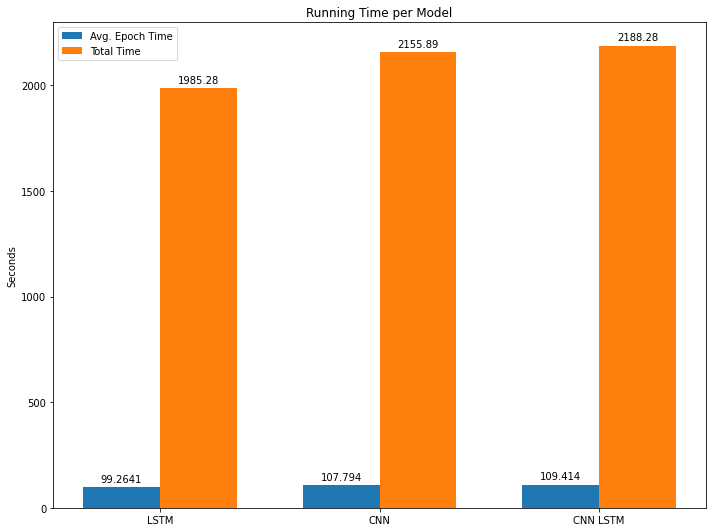

In [ ]:
# Plot running time comparison.
labels = ['LSTM', 'CNN', 'CNN LSTM']
time_per_epoch = [lstm_duration / NUM_EPOCHS, 
                  cnn_duration / NUM_EPOCHS, 
                  cnn_lstm_duration / NUM_EPOCHS]
total_time = [lstm_duration, cnn_duration, cnn_lstm_duration]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=[10,7.5])
ax.set_title('Running Time per Model')
ax.set_xticks(x, labels)
ax.set_ylabel('Seconds')

rects1 = ax.bar(x - width/2, time_per_epoch, width, label='Avg. Epoch Time')
rects2 = ax.bar(x + width/2, total_time, width, label='Total Time')

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

ax.legend()
fig.tight_layout()
plt.savefig("Model Comparison - Running Time.pdf")
plt.show()

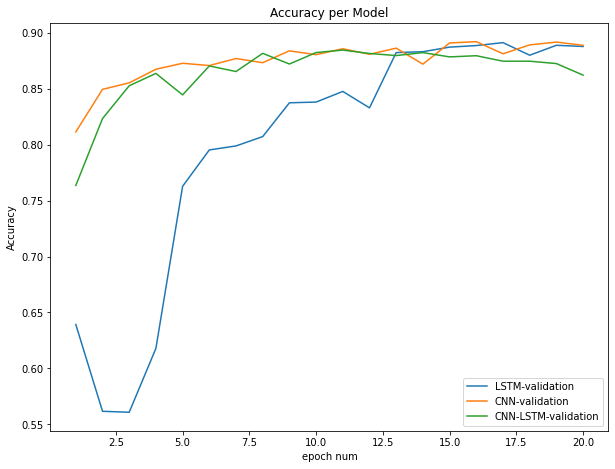

In [ ]:
epochs = [i + 1 for i in range(NUM_EPOCHS)]

# Plot accuracy comparison.
plt.figure(101, figsize=[10,7.5])
plt.title("Accuracy per Model")
plt.xlabel("epoch num")
plt.ylabel("Accuracy")

# plt.plot(epochs, lstm_train_acc, label="LSTM-training")
# plt.plot(epochs, cnn_train_acc, label="CNN-training")
# plt.plot(epochs, cnn_lstm_train_acc, label="CNN-LSTM-training")

plt.plot(epochs, lstm_valid_acc, label="LSTM-validation")
plt.plot(epochs, cnn_valid_acc, label="CNN-validation")
plt.plot(epochs, cnn_lstm_valid_acc, label="CNN-LSTM-validation")

plt.legend()
plt.savefig("Model Comparison - Accuracy.pdf")
plt.show()

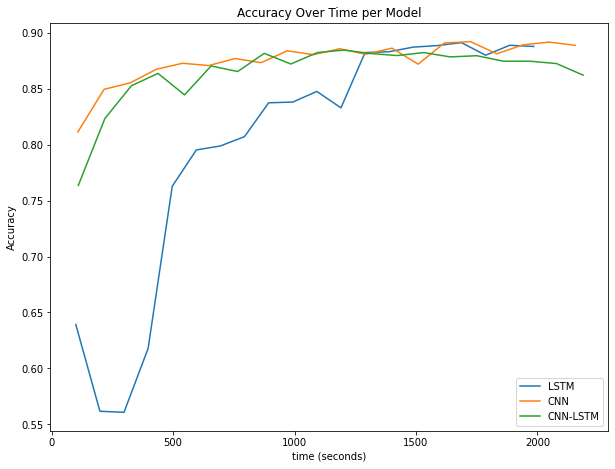

In [ ]:
# Plot accuracy over time comparisons.
fig, ax = plt.subplots(figsize=[10,7.5])
plt.title("Accuracy Over Time per Model")
plt.xlabel('time (seconds)')
plt.ylabel('Accuracy')

lstm_times = [time_per_epoch[0] for _ in range(len(lstm_valid_acc))]
cnn_times = [time_per_epoch[1] for _ in range(len(cnn_valid_acc))]
cnn_lstm_times = [time_per_epoch[2] for _ in range(len(cnn_lstm_valid_acc))]

ax.plot(np.cumsum(lstm_times), lstm_valid_acc, label="LSTM")
ax.plot(np.cumsum(cnn_times), cnn_valid_acc, label="CNN")
ax.plot(np.cumsum(cnn_lstm_times), cnn_lstm_valid_acc, label="CNN-LSTM")

legend = ax.legend()
plt.savefig("Model Comparisons - Accuracy Over Time.pdf")
plt.show()

In [ ]:
print("Accuracy on the test set for each model:")
print(f"LSTM\t\t= {lstm_test_acc:.2%}")
print(f"CNN\t\t= {cnn_test_acc:.2%}")
print(f"CNN-LSTM\t= {cnn_lstm_test_acc:.2%}")

Accuracy on the test set for each model:
LSTM		= 88.35%
CNN		= 88.11%
CNN-LSTM	= 88.27%


In [ ]:
print("Accuracy on the training set for each model:")
print(f"LSTM\t\t= {max(lstm_train_acc):.2%}")
print(f"CNN\t\t= {max(cnn_train_acc):.2%}")
print(f"CNN-LSTM\t= {max(cnn_lstm_train_acc):.2%}")

Accuracy on the training set for each model:
LSTM		= 94.41%
CNN		= 99.58%
CNN-LSTM	= 99.14%


In [ ]:
print("Accuracy on the validation set for each model:")
print(f"LSTM\t\t= {max(lstm_valid_acc):.2%}")
print(f"CNN\t\t= {max(cnn_valid_acc):.2%}")
print(f"CNN-LSTM\t= {max(cnn_lstm_valid_acc):.2%}")

Accuracy on the validation set for each model:
LSTM		= 89.11%
CNN		= 89.19%
CNN-LSTM	= 88.44%


# **Reference**

Source Code on which this work was based:
https://github.com/bentrevett/pytorch-sentiment-analysis